In [8]:
from prophet import Prophet
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
import plotly.offline as py
import matplotlib as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import holidays
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [3]:
training_upto = 2020
forecast_upto = (2023-training_upto-1)*12 +3

## Prediction Whole of Barnet

In [4]:
# Read data, get dataframe with crimes/month
monthly_grouped_df = pd.read_csv('C:\\Users\\20203697\\Downloads\\filtered_df_utility_cols.csv')
monthly_grouped_df= monthly_grouped_df.sort_values(['Year','Month num'],ascending=False).groupby(['Year', 'Month num'])['Crime type'].count()
monthly_grouped_df = monthly_grouped_df.to_frame()


# Rename columns, select rows with data and set datetime index
monthly_grouped_df = monthly_grouped_df.rename(columns = {'Month num':'y'})
monthly_grouped_df['day'] = 1
monthly_grouped_df = monthly_grouped_df.reset_index()
# monthly_grouped_df = monthly_grouped_df[(monthly_grouped_df['Year']>=2011) | ((monthly_grouped_df['Year'] == 2010) & (monthly_grouped_df['Month num']==12))]
monthly_grouped_df = monthly_grouped_df.rename(columns={'Month num': 'month', 'Year': 'year'})
monthly_grouped_df['ds'] = pd.to_datetime(monthly_grouped_df[['year', 'month', 'day']])
monthly_grouped_df['y'] = monthly_grouped_df['Crime type']
# monthly_grouped_df = monthly_grouped_df.set_index(pd.DatetimeIndex(monthly_grouped_df['Date']))

# Getting Holidays
holiday = pd.DataFrame([])
for date, name in sorted(holidays.country_holidays('GB', subdiv='England', years=[2012, 2013, 2014, 2015, 2016, 2017, 2018,2019,2020,2021, 2022, 2023, 2024]).items()):
    #holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "England-Holidays"}, index=[0]), ignore_index=True)
    holiday= pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': "England-Holidays"}, index=[0])], ignore_index=True)

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

# Divide test and train data
train_data = monthly_grouped_df[monthly_grouped_df['year']<(training_upto+1)]
test_data = monthly_grouped_df[(monthly_grouped_df['year']>training_upto)]

monthly_grouped_df


,year,month,Crime type,day,ds,y
0,2010,12,372,1,2010-12-01,372
1,2011,1,486,1,2011-01-01,486
2,2011,2,403,1,2011-02-01,403
3,2011,3,408,1,2011-03-01,408
4,2011,4,414,1,2011-04-01,414
...,...,...,...,...,...,...
143,2022,11,246,1,2022-11-01,246
144,2022,12,228,1,2022-12-01,228
145,2023,1,242,1,2023-01-01,242
146,2023,2,199,1,2023-02-01,199


### Hyper-parameter tuning

In [5]:
param_grid = { 
    'seasonality_mode':('multiplicative','additive'), 
    'changepoint_prior_scale': [0.05, 0.01, 0.15],
    'seasonality_prior_scale': [0.05, 0.01, 0.15],
    'holidays_prior_scale':[0.005,0.01,0.015],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the RMSEs for each params here

cutoffs = pd.date_range(start='2015-01-01', end='2021-12-01', freq='2MS')

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params, holidays= holiday).fit(monthly_grouped_df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
print("Mean absolute error: ", np.argmin(maes))
best_params = all_params[np.argmin(maes)]
print("Best parameters", best_params)

15:29:48 - cmdstanpy - INFO - Chain [1] start processing
15:29:48 - cmdstanpy - INFO - Chain [1] done processing


KeyboardInterrupt: 

16:36:40 - cmdstanpy - INFO - Chain [1] start processing
16:36:41 - cmdstanpy - INFO - Chain [1] done processing


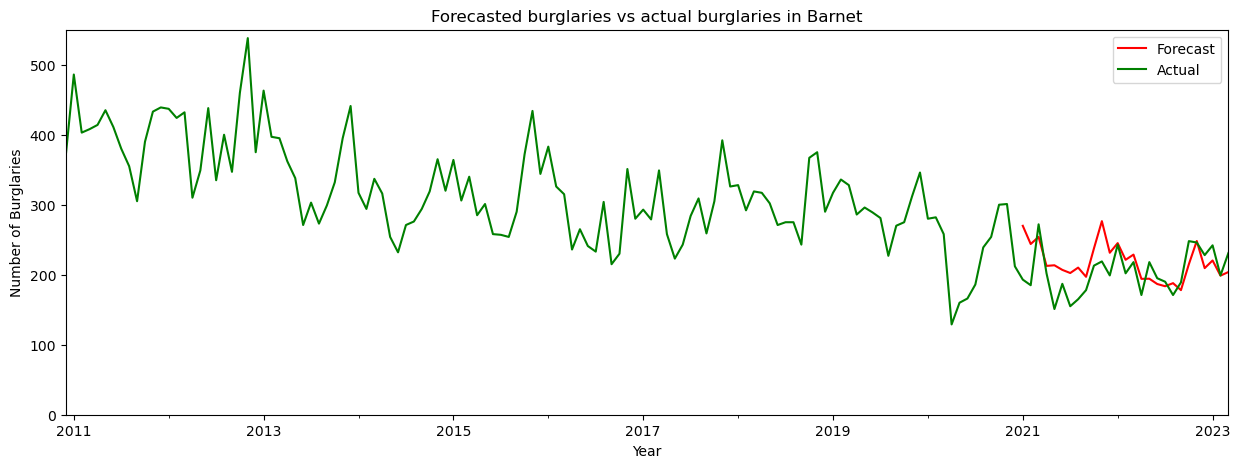

25.83032164474304
-0.17662392567218177


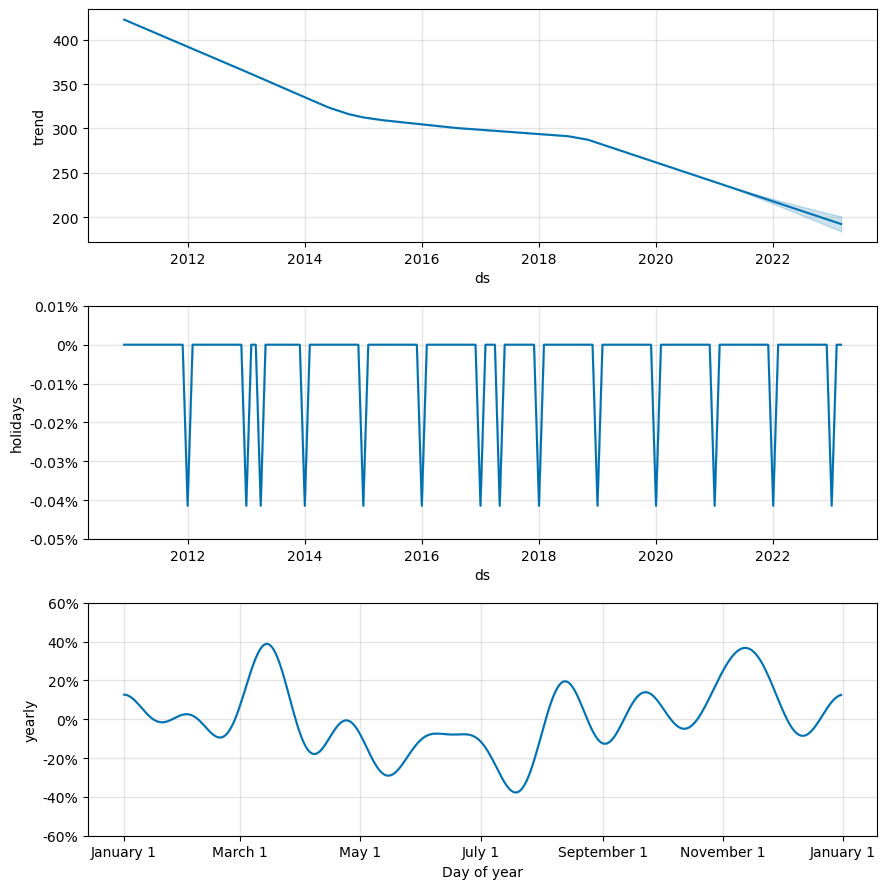

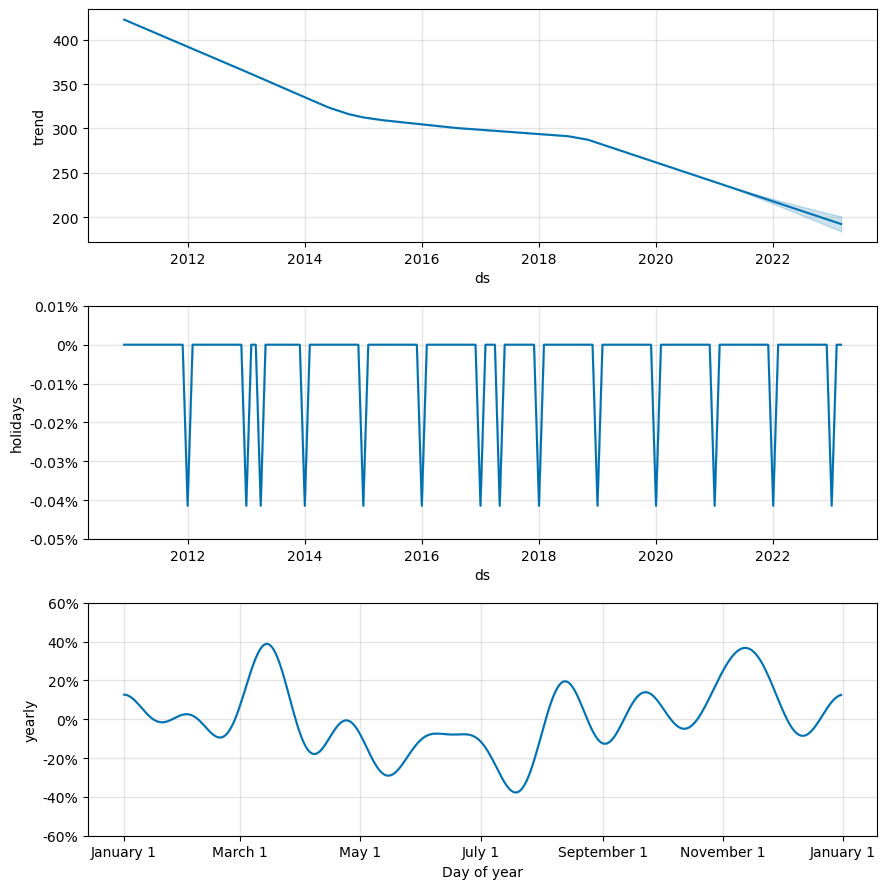

In [5]:
# Train the model with the best parameters and forecast

best_model = Prophet(seasonality_mode= 'multiplicative', changepoint_prior_scale= 0.15, seasonality_prior_scale= 0.15, holidays_prior_scale= 0.01, holidays= holiday).fit(train_data)
future_dates = best_model.make_future_dataframe(periods=forecast_upto, freq='MS')
forecast = best_model.predict(future_dates)

# Plot predictions
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
forecast[-forecast_upto:].plot(kind='line',x='ds', y='yhat', color='red', label='Forecast', ax=ax)
monthly_grouped_df.plot(kind='line',x='ds',y='y', color='green',label='Actual', ax=ax)
plt.title('Forecasted burglaries vs actual burglaries in Barnet')
plt.xlabel("Year")
plt.ylabel("Number of Burglaries")
plt.ylim(0,550)
plt.show()

print(mean_absolute_error(test_data['y'], forecast['yhat'][-forecast_upto:]))
print(r2_score(test_data['y'], forecast['yhat'][-forecast_upto:]))

best_model.plot_components(forecast)

## Prediction per ward

In [22]:
# Create the dataframe
file =  pd.read_csv('C:/Users/20203697/Downloads/filtered_df_utility_cols.csv')
df_per_ward= file.sort_values(['Year','Month num'],ascending=False).groupby(['Ward', 'Year', 'Month num']).count()
# Create a dataframe with the wanted dates
dates = pd.date_range(start='12/1/2010', end='3/1/2023', freq='MS').to_frame()
df_per_ward = df_per_ward.reset_index()
print(df_per_ward['Ward'].unique())

# Specify columns: ds, y, Date
df_per_ward['day'] = 1
df_per_ward = df_per_ward.reset_index()
df_per_ward['y'] = df_per_ward['Crime type']
df_per_ward = df_per_ward.rename(columns={'Month num': 'month', 'Year': 'year'})
df_per_ward['ds'] = pd.to_datetime(df_per_ward[['year', 'month', 'day']])
df_per_ward['Date'] = df_per_ward['ds']
dates['Date'] = dates[0]
dates = dates[['Date']]

['Barnet Vale' 'Brunswick Park' 'Burnt Oak' 'Childs Hill'
 'Colindale North' 'Colindale South' 'Cricklewood' 'East Barnet'
 'East Finchley' 'Edgware' 'Edgwarebury' 'Finchley Church End'
 'Friern Barnet' 'Garden Suburb' 'Golders Green' 'Hendon' 'High Barnet'
 'Mill Hill' 'Nan' 'Totteridge and Woodside' 'Underhill' 'West Finchley'
 'West Hendon' 'Whetstone' 'Woodhouse']


C:\Users\20203697\AppData\Local\Temp\ipykernel_5712\372263130.py:38: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

17:07:59 - cmdstanpy - INFO - Chain [1] start processing
17:07:59 - cmdstanpy - INFO - Chain [1] done processing


Brunswick Park


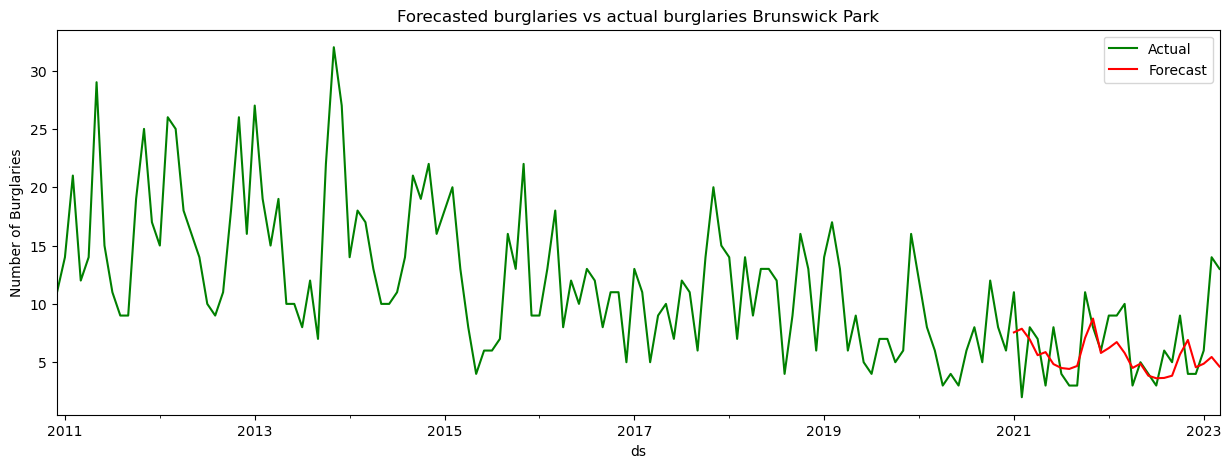

C:\Users\20203697\AppData\Local\Temp\ipykernel_5712\372263130.py:38: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

17:08:00 - cmdstanpy - INFO - Chain [1] start processing
17:08:00 - cmdstanpy - INFO - Chain [1] done processing


Burnt Oak


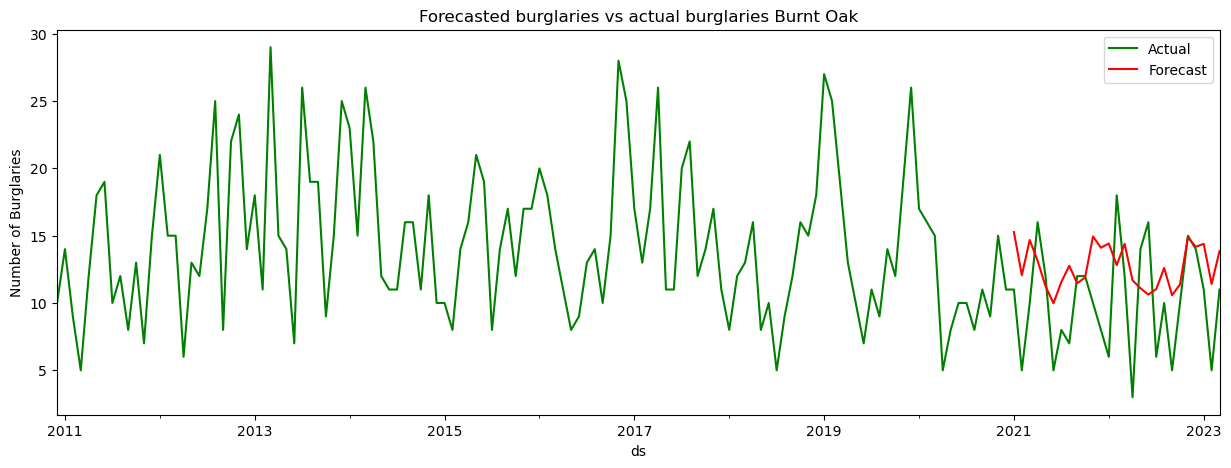

C:\Users\20203697\AppData\Local\Temp\ipykernel_5712\372263130.py:38: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

17:08:00 - cmdstanpy - INFO - Chain [1] start processing
17:08:00 - cmdstanpy - INFO - Chain [1] done processing


Childs Hill


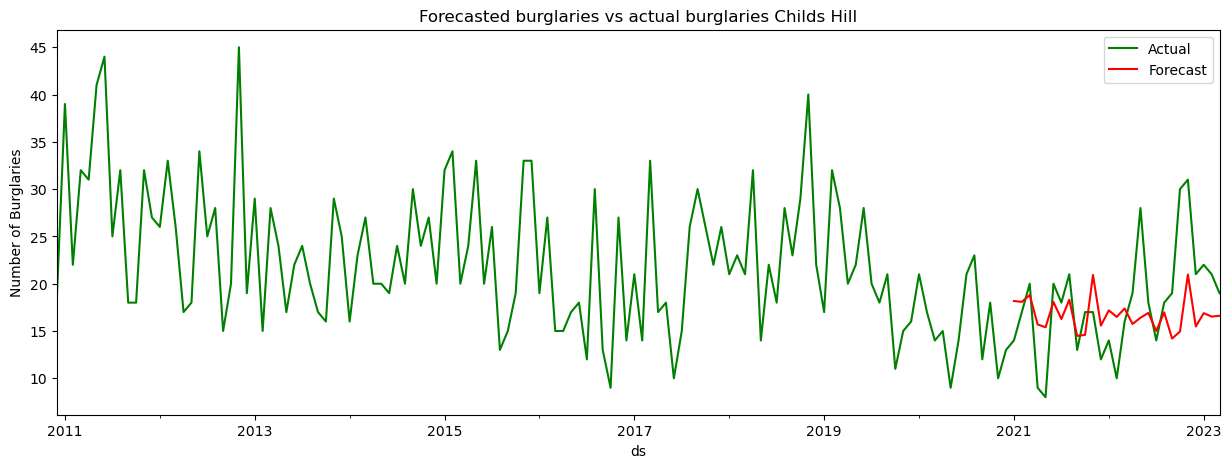

C:\Users\20203697\AppData\Local\Temp\ipykernel_5712\372263130.py:38: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

17:08:01 - cmdstanpy - INFO - Chain [1] start processing
17:08:01 - cmdstanpy - INFO - Chain [1] done processing


East Barnet


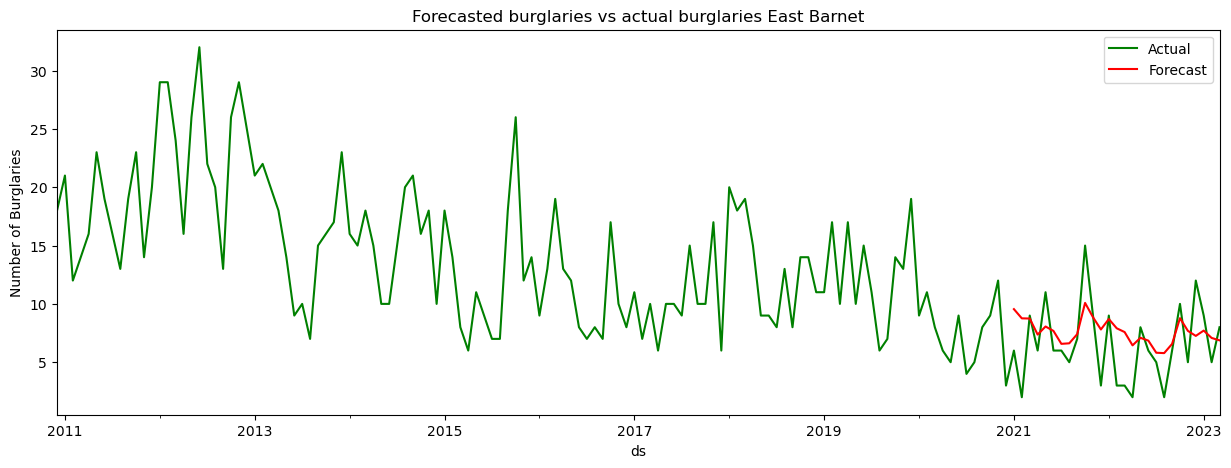

C:\Users\20203697\AppData\Local\Temp\ipykernel_5712\372263130.py:38: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

17:08:01 - cmdstanpy - INFO - Chain [1] start processing
17:08:01 - cmdstanpy - INFO - Chain [1] done processing


East Finchley


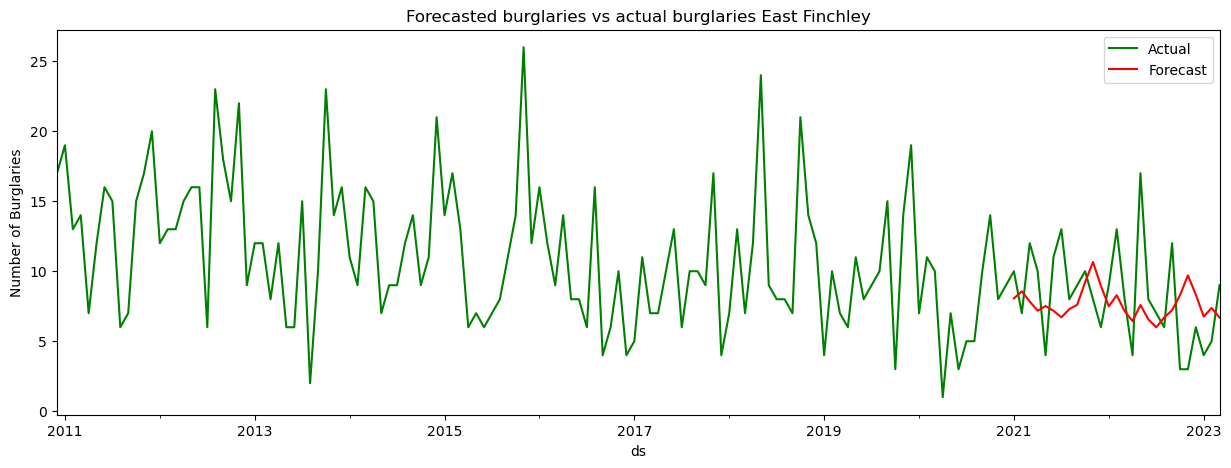

C:\Users\20203697\AppData\Local\Temp\ipykernel_5712\372263130.py:38: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

17:08:02 - cmdstanpy - INFO - Chain [1] start processing
17:08:02 - cmdstanpy - INFO - Chain [1] done processing


Edgware


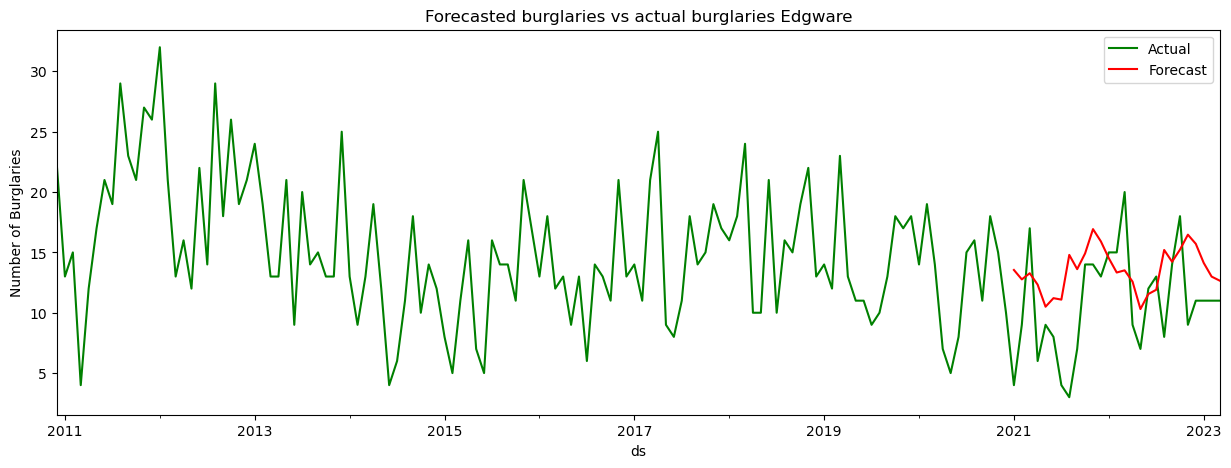

C:\Users\20203697\AppData\Local\Temp\ipykernel_5712\372263130.py:38: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

17:08:03 - cmdstanpy - INFO - Chain [1] start processing
17:08:03 - cmdstanpy - INFO - Chain [1] done processing


Finchley Church End


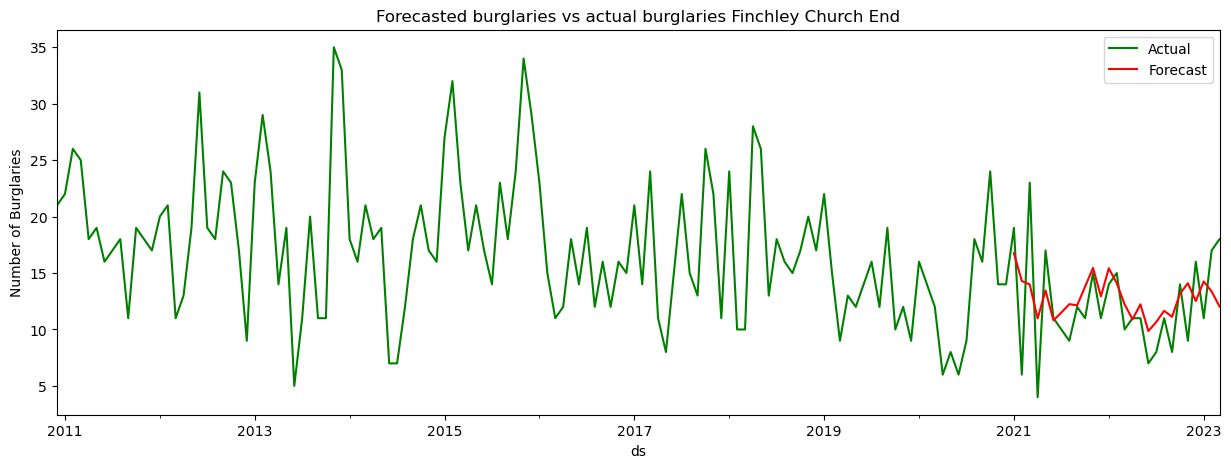

C:\Users\20203697\AppData\Local\Temp\ipykernel_5712\372263130.py:38: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

17:08:03 - cmdstanpy - INFO - Chain [1] start processing
17:08:03 - cmdstanpy - INFO - Chain [1] done processing


Garden Suburb


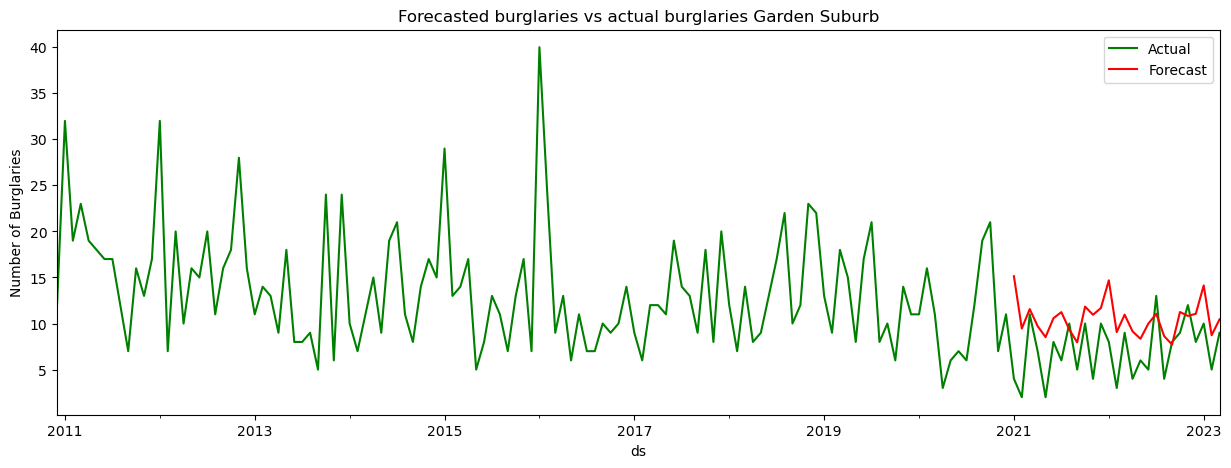

C:\Users\20203697\AppData\Local\Temp\ipykernel_5712\372263130.py:38: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

17:08:04 - cmdstanpy - INFO - Chain [1] start processing
17:08:04 - cmdstanpy - INFO - Chain [1] done processing


Golders Green


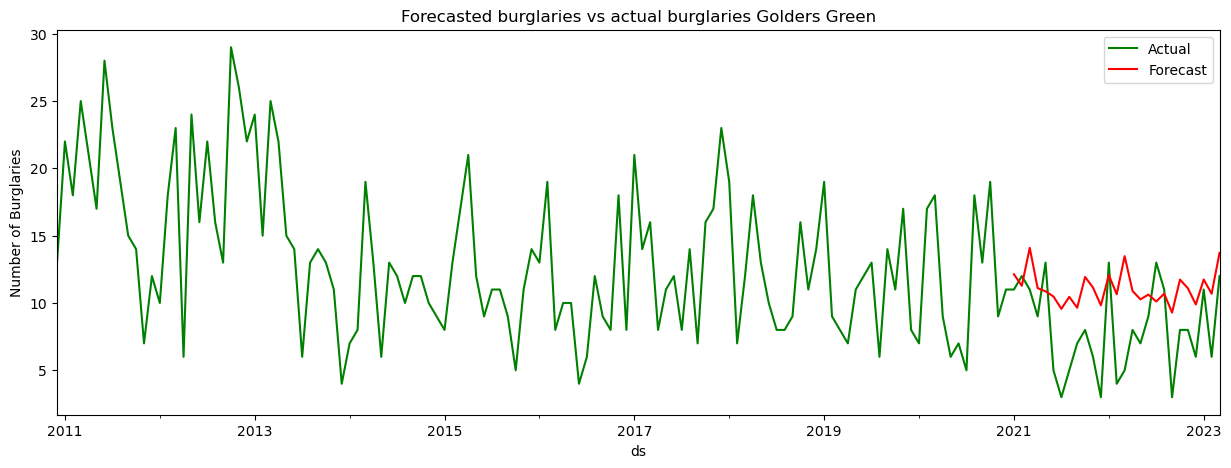

C:\Users\20203697\AppData\Local\Temp\ipykernel_5712\372263130.py:38: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

17:08:04 - cmdstanpy - INFO - Chain [1] start processing
17:08:04 - cmdstanpy - INFO - Chain [1] done processing


Hendon


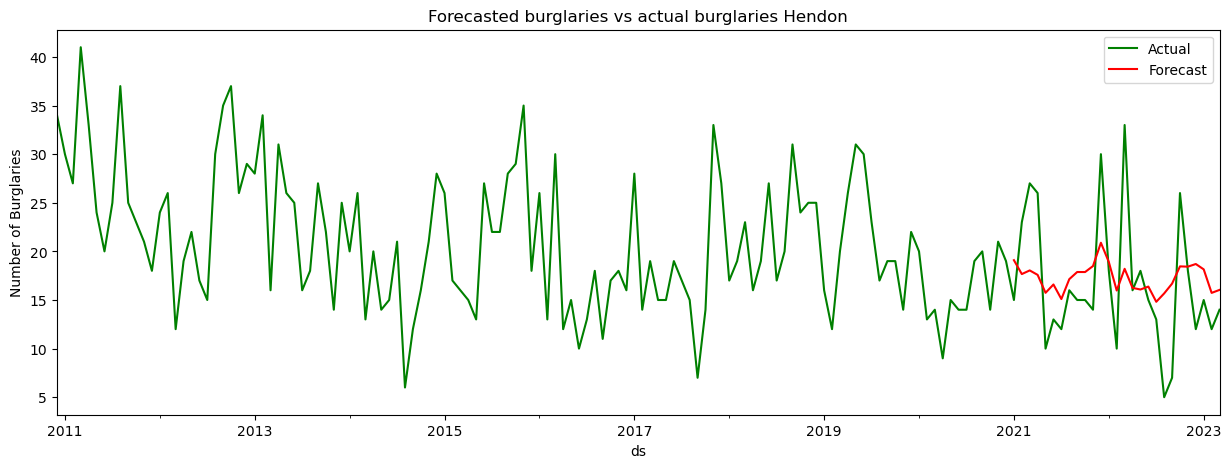

C:\Users\20203697\AppData\Local\Temp\ipykernel_5712\372263130.py:38: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

17:08:05 - cmdstanpy - INFO - Chain [1] start processing
17:08:05 - cmdstanpy - INFO - Chain [1] done processing


High Barnet


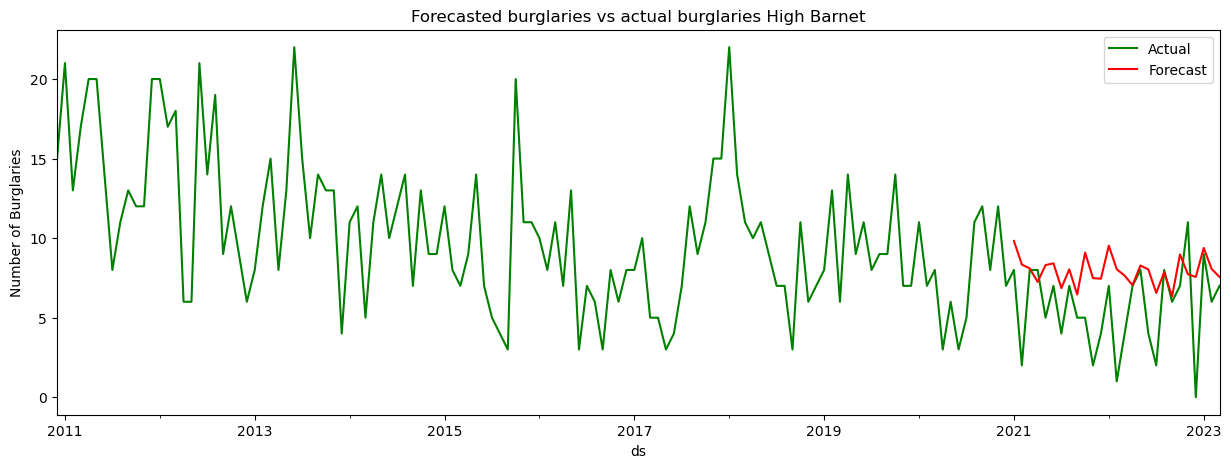

C:\Users\20203697\AppData\Local\Temp\ipykernel_5712\372263130.py:38: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

17:08:06 - cmdstanpy - INFO - Chain [1] start processing
17:08:06 - cmdstanpy - INFO - Chain [1] done processing


Mill Hill


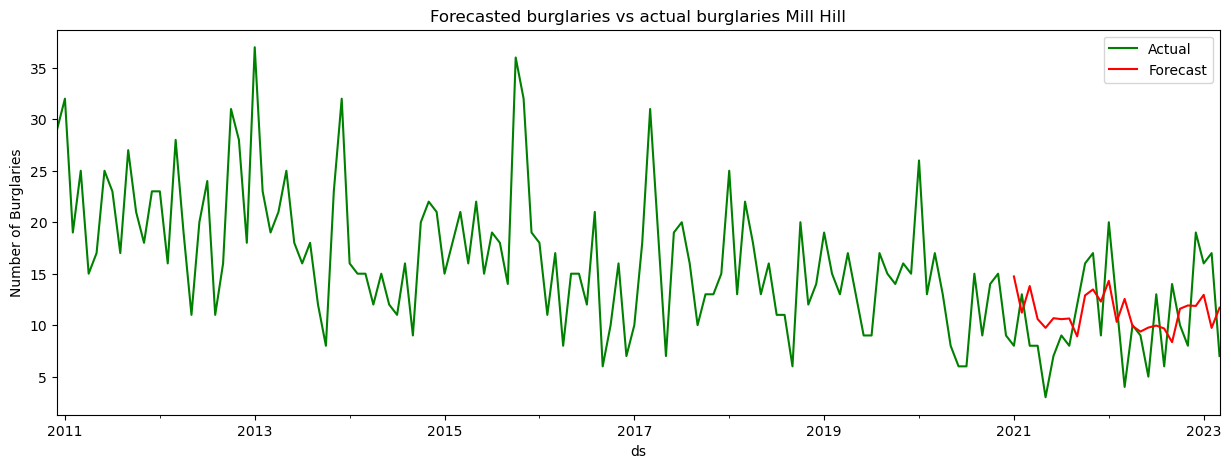

C:\Users\20203697\AppData\Local\Temp\ipykernel_5712\372263130.py:38: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

17:08:06 - cmdstanpy - INFO - Chain [1] start processing
17:08:06 - cmdstanpy - INFO - Chain [1] done processing


Underhill


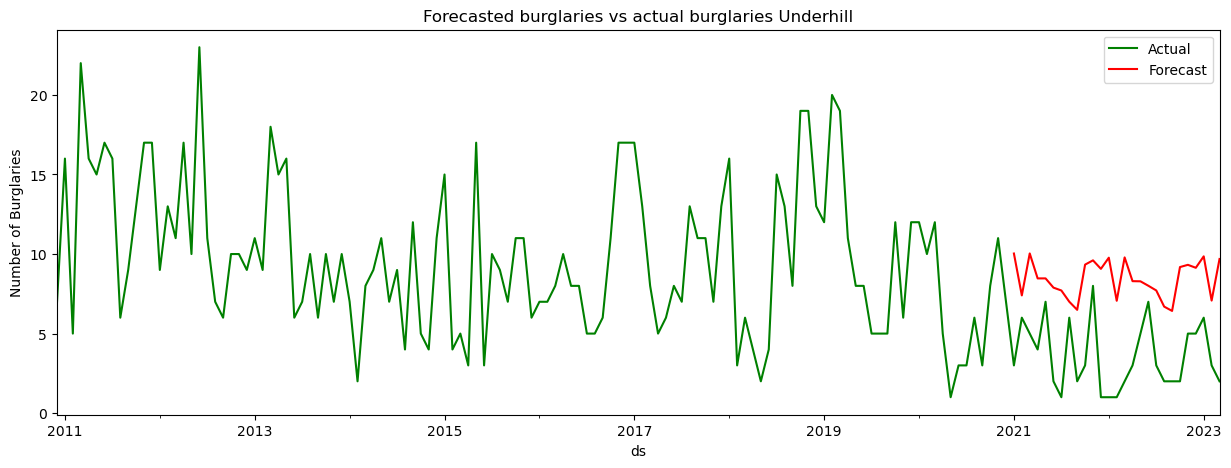

C:\Users\20203697\AppData\Local\Temp\ipykernel_5712\372263130.py:38: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

17:08:07 - cmdstanpy - INFO - Chain [1] start processing
17:08:07 - cmdstanpy - INFO - Chain [1] done processing


West Finchley


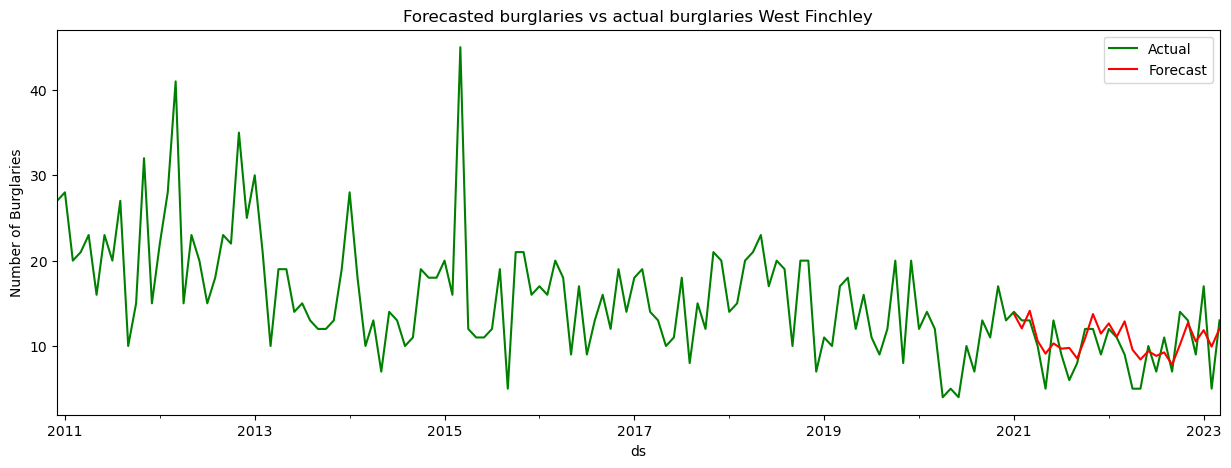

C:\Users\20203697\AppData\Local\Temp\ipykernel_5712\372263130.py:38: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

17:08:08 - cmdstanpy - INFO - Chain [1] start processing
17:08:08 - cmdstanpy - INFO - Chain [1] done processing


West Hendon


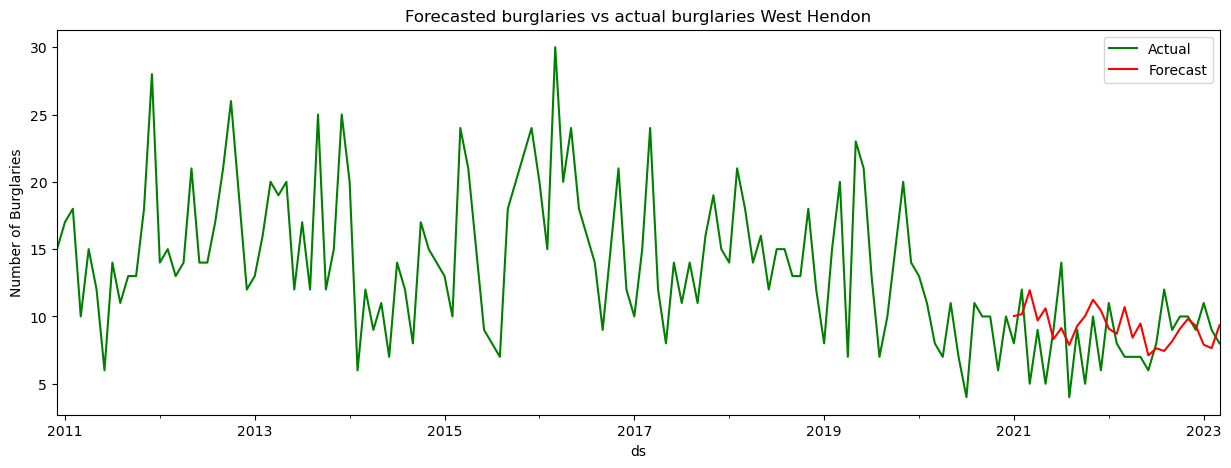

C:\Users\20203697\AppData\Local\Temp\ipykernel_5712\372263130.py:38: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

17:08:08 - cmdstanpy - INFO - Chain [1] start processing
17:08:08 - cmdstanpy - INFO - Chain [1] done processing


Woodhouse


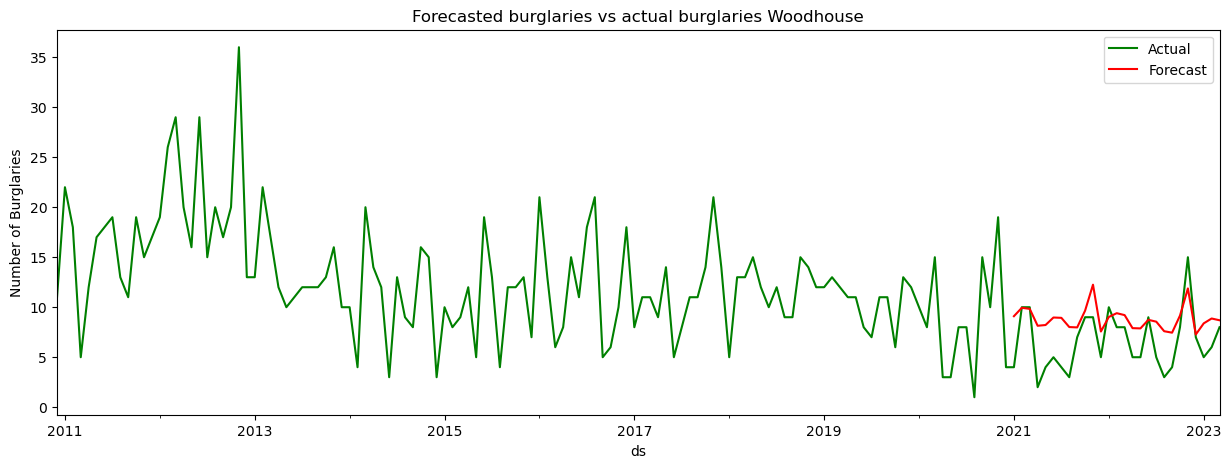

3.32506451095906


In [23]:
#print(df_per_ward)

# Get holiday dataset
holiday = pd.DataFrame([])
for date, name in sorted(holidays.country_holidays('GB', subdiv='England', years=[2012, 2013, 2014, 2015, 2016, 2017, 2018,2019,2020,2021, 2022, 2023]).items()):
    holiday= pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': "England-Holidays"}, index=[0])], ignore_index=True)

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

# Create a dataframe with the wanted dates
dates = pd.date_range(start='12/1/2010', end='3/1/2023', freq='MS').to_frame()

# Specify columns: ds, y, Date
df_per_ward['day'] = 1
df_per_ward = df_per_ward.reset_index()
df_per_ward = df_per_ward.rename(columns={'Month num': 'month', 'Year': 'year'})
df_per_ward['ds'] = pd.to_datetime(df_per_ward[['year', 'month', 'day']])
df_per_ward['Date'] = df_per_ward['ds']
dates['Date'] = dates[0]
dates = dates[['Date']]

# Loop over wards
wards = ['Brunswick Park', 'Burnt Oak', 'Childs Hill', 'East Barnet',
       'East Finchley', 'Edgware', 'Finchley Church End', 'Garden Suburb',
       'Golders Green', 'Hendon', 'High Barnet', 'Mill Hill', 'Underhill',
       'West Finchley', 'West Hendon', 'Woodhouse']
mse = []
mae = []

for ward in wards: 
       # Select data of ward
       df_ward = df_per_ward[df_per_ward['Ward']==ward]
       df_ward = df_ward[['ds', 'Date', 'year', 'y', 'Population per square kilometre']]
       # Merge with all dates to have a consistent dataframe
       df_ward = pd.merge(dates, df_ward, how="left", on='Date')
       df_ward['ds'] = df_ward['Date']
       df_ward['y'] = df_ward['y'].fillna(0)
       df_ward = df_ward.fillna(df_ward.mean())
       df_ward['year'] = pd.DatetimeIndex(df_ward['Date']).year
       train_ward = df_ward[df_ward['year']<(training_upto+1)]
       test_ward = df_ward[(df_ward['year']>training_upto)] 
       best_model = Prophet(seasonality_mode= 'multiplicative', changepoint_prior_scale= 0.15, seasonality_prior_scale= 0.15, holidays_prior_scale= 0.01, holidays= holiday)
       best_model.add_regressor('Population per square kilometre')
       best_model.fit(train_ward)
       future_dates = best_model.make_future_dataframe(periods=forecast_upto, freq='MS')
       future_dates = pd.merge(future_dates, df_ward, how="left", on='ds')
       forecast = best_model.predict(future_dates)
       print(ward)
       mae.append(mean_absolute_error(test_ward['y'], forecast['yhat'][-forecast_upto:]))
       mse.append(mean_squared_error(test_ward['y'], forecast['yhat'][-forecast_upto:]))
       f, ax = plt.subplots(figsize=(14,5))
       f.set_figheight(5)
       ax.set_xlabel("Year")
       ax.set_ylabel("Number of Burglaries")
       f.set_figwidth(15)
       
       df_ward.plot(kind='line',x='ds',y='y', color='green',label='Actual', ax=ax)
       forecast[-forecast_upto:].plot(kind='line',x='ds', y='yhat', color='red', label='Forecast', ax=ax)
       title = 'Forecasted burglaries vs actual burglaries ' + ward
       plt.title(title)
       plt.show()

print(np.mean(mae))
       

In [8]:

# Get holiday dataset
holiday = pd.DataFrame([])
for date, name in sorted(holidays.country_holidays('GB', subdiv='England', years=[2012, 2013, 2014, 2015, 2016, 2017, 2018,2019,2020,2021, 2022, 2023]).items()):
    holiday= pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': "England-Holidays"}, index=[0])], ignore_index=True)

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

# Create a dataframe with the wanted dates
dates = pd.date_range(start='12/1/2010', end='3/1/2023', freq='MS').to_frame()

# Specify columns: ds, y, Date
df_per_ward['day'] = 1
df_per_ward = df_per_ward.reset_index()
df_per_ward = df_per_ward.rename(columns={'Month num': 'month', 'Year': 'year'})
df_per_ward['ds'] = pd.to_datetime(df_per_ward[['year', 'month', 'day']])
df_per_ward['Date'] = df_per_ward['ds']
dates['Date'] = dates[0]
dates = dates[['Date']]

# Loop over wards

df_ward = df_per_ward[df_per_ward['Ward']=='Burnt Oak']
df_ward = df_ward[['ds', 'Date', 'year', 'y', 'Population per square kilometre']]
print('df ward', df_ward.columns)
# Merge with all dates to have a consistent dataframe
df_ward = pd.merge(dates, df_ward, how="left", on='Date')
df_ward['ds'] = df_ward['Date']
df_ward['y'] = df_ward['y'].fillna(0)
df_ward = df_ward.fillna(df_ward.mean())
df_ward['year'] = pd.DatetimeIndex(df_ward['Date']).year
# Hyper parameter tuning

param_grid = { 
    'seasonality_mode':('multiplicative','additive'), 
    'changepoint_prior_scale': [0.05, 0.01, 0.15],
    'seasonality_prior_scale': [0.05, 0.01, 0.15],
    'holidays_prior_scale':[0.005,0.01,0.015],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the RMSEs for each params here

cutoffs = pd.date_range(start='2015-01-01', end='2021-12-01', freq='2MS')

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params, holidays= holiday).fit(df_ward)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
print("Mean absolute error: ", np.argmin(maes))
best_params = all_params[np.argmin(maes)]
print("Best parameters", best_params)






C:\Users\20203697\AppData\Local\Temp\ipykernel_5720\411593980.py:29: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

15:30:16 - cmdstanpy - INFO - Chain [1] start processing


df ward Index(['ds', 'Date', 'year', 'y', 'Population per square kilometre'], dtype='object')


15:30:16 - cmdstanpy - INFO - Chain [1] done processing
15:30:26 - cmdstanpy - INFO - Chain [1] start processing
15:30:26 - cmdstanpy - INFO - Chain [1] done processing
15:30:38 - cmdstanpy - INFO - Chain [1] start processing
15:30:38 - cmdstanpy - INFO - Chain [1] done processing
15:30:48 - cmdstanpy - INFO - Chain [1] start processing
15:30:48 - cmdstanpy - INFO - Chain [1] done processing
15:30:58 - cmdstanpy - INFO - Chain [1] start processing
15:30:59 - cmdstanpy - INFO - Chain [1] done processing
15:31:09 - cmdstanpy - INFO - Chain [1] start processing
15:31:10 - cmdstanpy - INFO - Chain [1] done processing
15:31:21 - cmdstanpy - INFO - Chain [1] start processing
15:31:21 - cmdstanpy - INFO - Chain [1] done processing
15:31:32 - cmdstanpy - INFO - Chain [1] start processing
15:31:32 - cmdstanpy - INFO - Chain [1] done processing
15:31:44 - cmdstanpy - INFO - Chain [1] start processing
15:31:44 - cmdstanpy - INFO - Chain [1] done processing
15:31:55 - cmdstanpy - INFO - Chain [1] 

Mean absolute error:  20
Best parameters {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.15, 'seasonality_prior_scale': 0.05, 'holidays_prior_scale': 0.015}
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')


15:42:31 - cmdstanpy - INFO - Chain [1] start processing
15:42:31 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
143 2022-11-01
144 2022-12-01
145 2023-01-01
146 2023-02-01
147 2023-03-01

[148 rows x 1 columns]


NameError: name 'ward' is not defined

16:23:36 - cmdstanpy - INFO - Chain [1] start processing
16:23:36 - cmdstanpy - INFO - Chain [1] done processing


Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')
            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
143 2022-11-01
144 2022-12-01
145 2023-01-01
146 2023-02-01
147 2023-03-01

[148 rows x 1 columns]
-0.6303103400160333


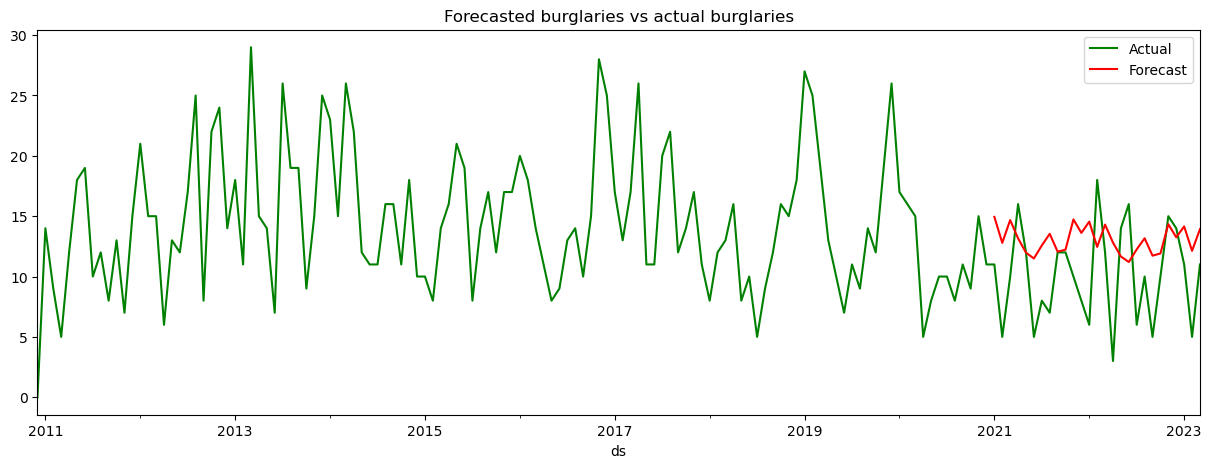

In [17]:
train_ward = df_ward[df_ward['year']<(training_upto+1)]
test_ward = df_ward[(df_ward['year']>training_upto)] 
print(df_ward.columns)
best_model = Prophet(seasonality_mode= 'multiplicative', changepoint_prior_scale= 0.15, seasonality_prior_scale= 0.05, holidays_prior_scale= 0.015, holidays= holiday)
best_model.add_regressor('Population per square kilometre')
best_model.fit(train_ward)
future_dates = best_model.make_future_dataframe(periods=forecast_upto, freq='MS')
print(future_dates)
future_dates = pd.merge(future_dates, df_ward, how="left", on='ds')
forecast = best_model.predict(future_dates)

print(r2_score(test_ward[['y']], forecast['yhat'][-forecast_upto:]))
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)

df_ward.plot(kind='line',x='ds',y='y', color='green',label='Actual', ax=ax)
forecast[-forecast_upto:].plot(kind='line',x='ds', y='yhat', color='red', label='Forecast', ax=ax)
plt.title('Forecasted burglaries vs actual burglaries')
plt.show()